In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import sys
sys.path.append("../src/")
sys.path.append("D:/metabolome_inference/metabolome_inference/src/")
from integrAitor import rawData,integrAitor,Classifier,Smoother,normalizeMatrix,safeNormalize
import detection_helper
import scipy.stats as stats
import seaborn as sb


In [2]:
datadir = "../data/mzMLs/plasma/"
resolution = 100
ppm = 10

In [3]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = {}
ms1 = {file:deimos.read_mzml(datadir + file)["ms1"] for file in files}
raw_data = {}
for file in files:
    temp = rawData()
    temp.readRawDataFile(datadir + file,ppm)
    raw_data[file] = temp
    

['WU350-075_d7_neg_ID_04.mzML', 'WU350-087_d0_ID_04.mzML', 'WU350-092_d14_neg_ID_04.mzML']


In [4]:
if __name__ == "__main__":
    # initialize ms1 peak container
    ms1_peaks = {}
    # iterate over ms1 datasets
    for k in ms1.keys():
        # partition data into chunks to limit memory usage
        # more on partitioning/mapping later in this notebook
        partitions = deimos.partition(ms1[k],
                                      split_on='mz',
                                      size=500,
                                      overlap=0.05)

        # map peakpicking algorithm to each partition
        # note that more configuration parameters are available
        ms1_peaks[k] = partitions.map(deimos.peakpick.local_maxima,
                                      dims=['mz', 'retention_time'],bins=[2.7, 3.64],
                                      processes=10)

Text(0, 0.5, '# of features')

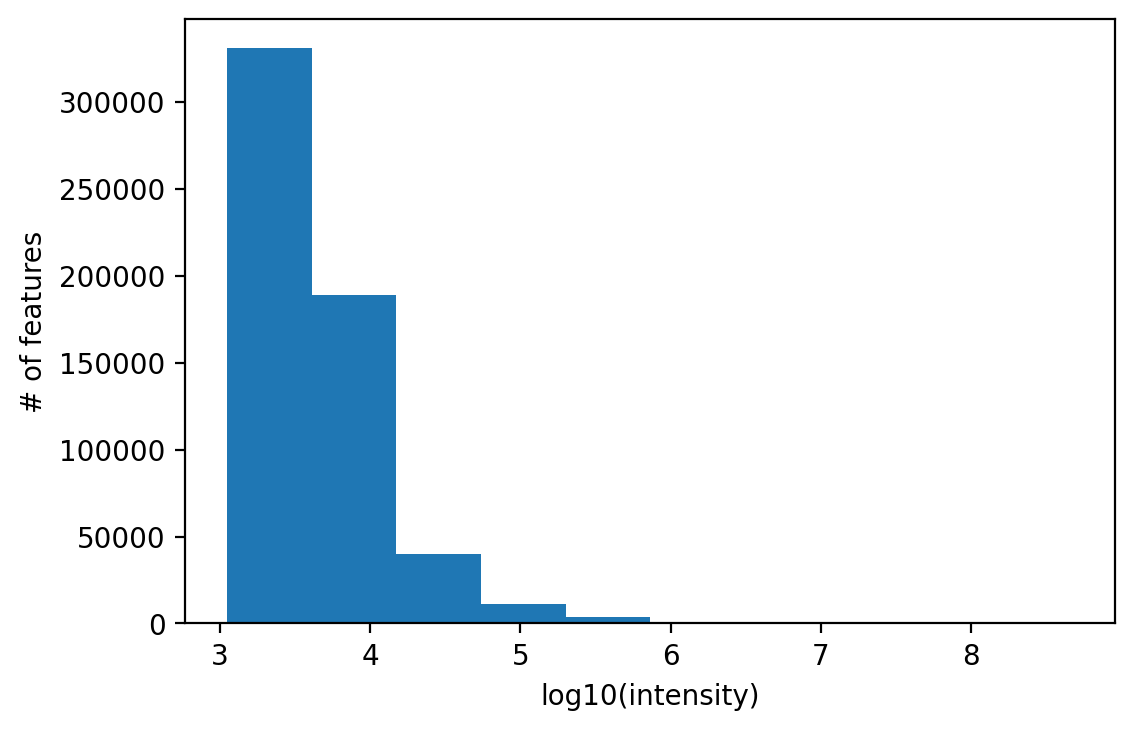

In [5]:
ints = []
for file in ms1_peaks:
    ints += list(np.log10(ms1_peaks[file]["intensity"].values))
plt.hist(ints)
plt.xlabel("log10(intensity)")
plt.ylabel("# of features")

In [6]:
# threshold by intensity
ms1_peaks_thresh = {key:deimos.threshold(value, threshold=10000) for key,value in ms1_peaks.items()}

In [7]:
dets = []
for file in ms1_peaks_thresh:
    dets.append(len(ms1_peaks_thresh[file]))
print(np.mean(dets),np.std(dets))

29981.666666666668 26499.82845646783


In [8]:
#format X
if __name__ == "__main__":
    X = np.zeros((int(np.sum([len(ms1_peaks_thresh[f]) for f in files])),resolution))
    integ = integrAitor(numCores = 10,resolution=resolution)
    keys = []
    i = 0

    for file in files:
        tmp = integ.makeDataMatrix([raw_data[file]],ms1_peaks_thresh[file]["mz"].values,
                                 ms1_peaks_thresh[file]["retention_time"].values-.5,
                                 ms1_peaks_thresh[file]["retention_time"].values+.5)
        X[i:i+len(tmp),:] = tmp        
        i += len(tmp)
        keys += [[file,ind] for ind in ms1_peaks_thresh[file].index.values]

X = X[:i]
print(X.shape)

forming matrix |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
forming matrix |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
forming matrix |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
(89945, 100)


In [9]:
if __name__ == "__main__":
    X_smoothed,tics,y,progress = integ.curatePeaks(X)

fitting smoother...
Epoch 1/10
1265/1265 [==============================] - 26s 20ms/step - loss: 0.1637 - mean_absolute_error: 0.0951 - val_loss: 0.0512 - val_mean_absolute_error: 0.0045
Epoch 2/10
1265/1265 [==============================] - 24s 19ms/step - loss: 0.0516 - mean_absolute_error: 0.0038 - val_loss: 0.0495 - val_mean_absolute_error: 0.0024
Epoch 3/10
1265/1265 [==============================] - 25s 19ms/step - loss: 0.0505 - mean_absolute_error: 0.0025 - val_loss: 0.0493 - val_mean_absolute_error: 0.0020
Epoch 4/10
1265/1265 [==============================] - 25s 19ms/step - loss: 0.0502 - mean_absolute_error: 0.0022 - val_loss: 0.0491 - val_mean_absolute_error: 0.0018
Epoch 5/10
1265/1265 [==============================] - 25s 19ms/step - loss: 0.0501 - mean_absolute_error: 0.0021 - val_loss: 0.0491 - val_mean_absolute_error: 0.0017
Epoch 6/10
1265/1265 [==============================] - 25s 19ms/step - loss: 0.0500 - mean_absolute_error: 0.0020 - val_loss: 0.0490 - val_

3784/3784 [==============================] - 20s 5ms/step - loss: 0.0076 - mean_absolute_error: 0.0028 - val_loss: 0.0078 - val_mean_absolute_error: 0.0025
Epoch 9/10
3784/3784 [==============================] - 19s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0026 - val_loss: 0.0065 - val_mean_absolute_error: 0.0020
Epoch 10/10
3784/3784 [==============================] - 20s 5ms/step - loss: 0.0068 - mean_absolute_error: 0.0025 - val_loss: 0.0069 - val_mean_absolute_error: 0.0022
round 5: 689 unclassified features
Epoch 1/10
3785/3785 [==============================] - 20s 5ms/step - loss: 0.6030 - mean_absolute_error: 0.4127 - val_loss: 0.0583 - val_mean_absolute_error: 0.0152
Epoch 2/10
3785/3785 [==============================] - 20s 5ms/step - loss: 0.0475 - mean_absolute_error: 0.0163 - val_loss: 0.0195 - val_mean_absolute_error: 0.0043
Epoch 3/10
3785/3785 [==============================] - 20s 5ms/step - loss: 0.0237 - mean_absolute_error: 0.0087 - val_loss: 0.0114 - val_m

[89945, 2438, 1241, 816, 689]


Text(0, 0.5, 'log10(# of uncertain peaks)')

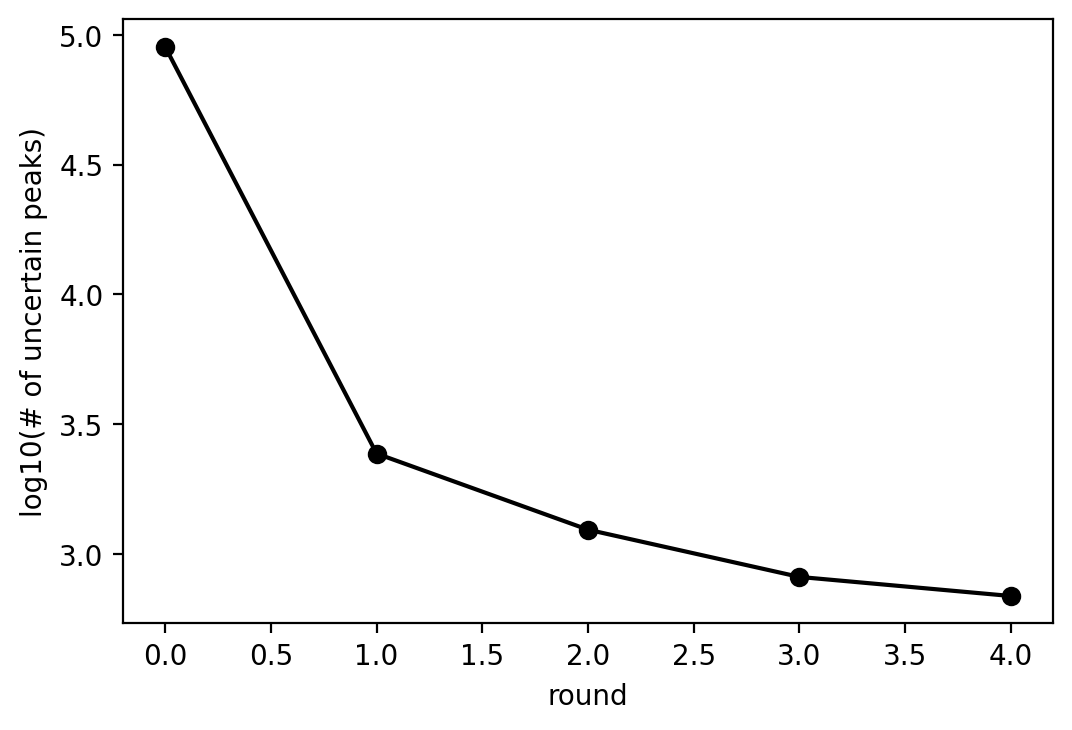

In [10]:
print(progress)
plt.plot(list(range(len(progress))),np.log10(progress),color="black")
plt.scatter(list(range(len(progress))),np.log10(progress),color="black")
plt.xlabel("round")
plt.ylabel("log10(# of uncertain peaks)")

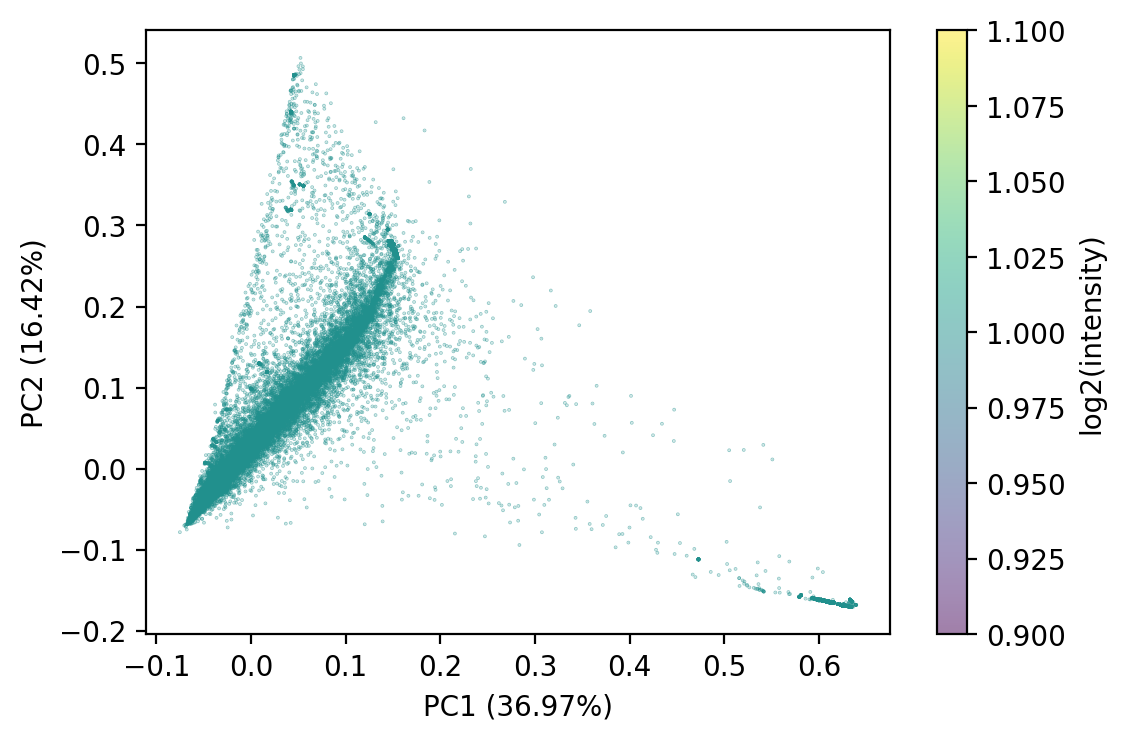

In [11]:
pca = PCA(2)
loads = pca.fit_transform(X_smoothed)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log2(intensity)")

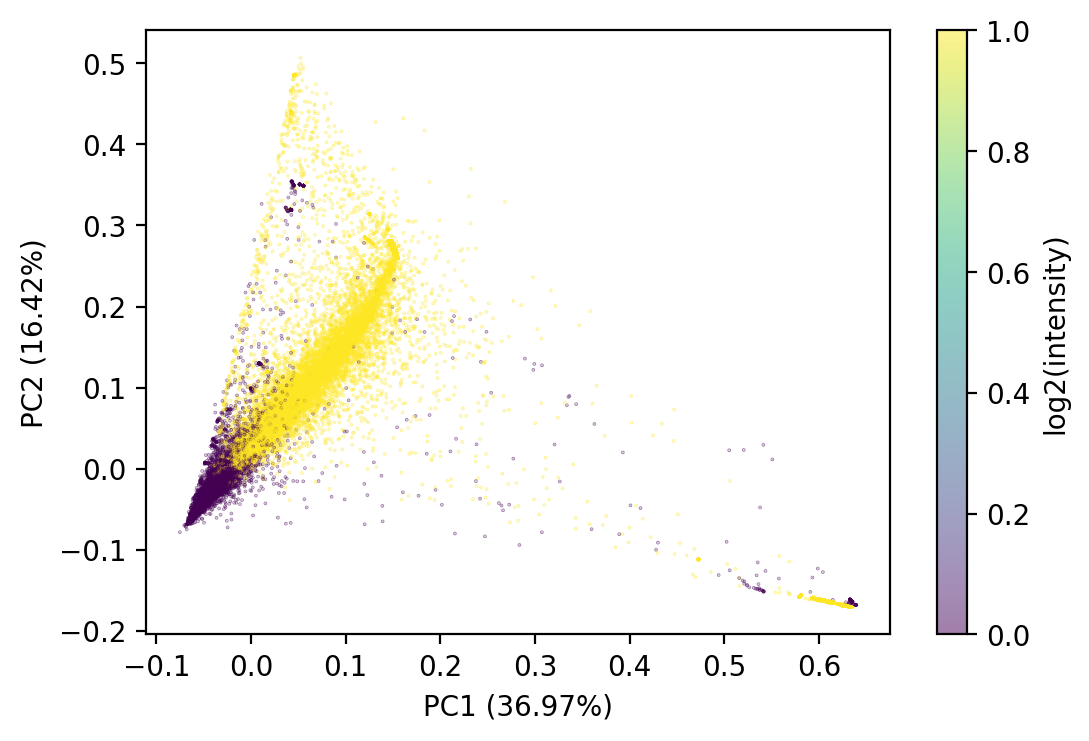

In [12]:
pca = PCA(2)
loads = pca.fit_transform(X_smoothed)
plt.scatter(loads[:,0],loads[:,1],c=y,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log2(intensity)")

In [13]:
ms1_peaks_curated = {file:[] for file in files}
for [file,index],score in zip(keys,y):
    if score > .5:
        ms1_peaks_curated[file].append(index)
for file in ms1_peaks_curated:
    ms1_peaks_curated[file] = ms1_peaks_thresh[file].loc[ms1_peaks_curated[file],:]

Text(0, 0.5, '% of features')

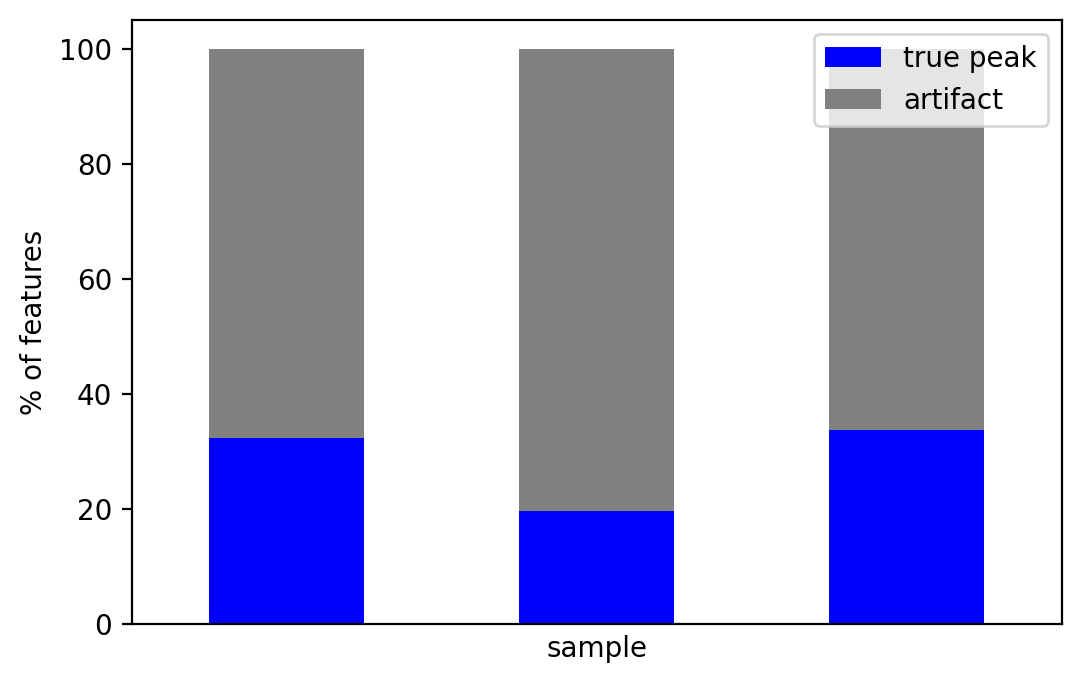

In [17]:
df = {}
for file in ms1_peaks_thresh:
    for index,row in ms1_peaks_thresh[file].iterrows():
        if index in ms1_peaks_curated[file].index.values:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["blue","grey"])
plt.xticks([],[])
plt.ylabel("% of features")

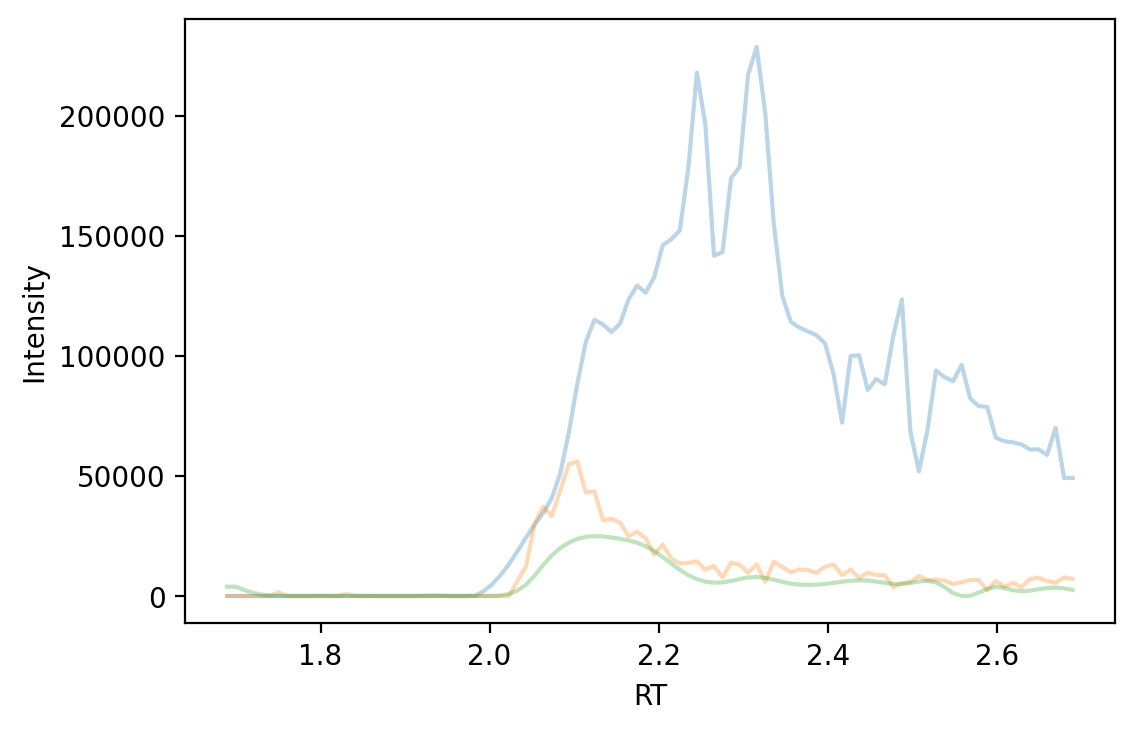

In [15]:
file = files[0]
inds = list(ms1_peaks_thresh[file].index.values)
rd.shuffle(inds)
for i in inds:
    if i in ms1_peaks_curated[file].index.values:
        integ.plot_overlayedEIC([raw_data[f] for f in files],ms1_peaks_curated[file].at[i,"mz"],ms1_peaks_curated[file].at[i,"retention_time"]-.5,ms1_peaks_curated[file].at[i,"retention_time"] + .5)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

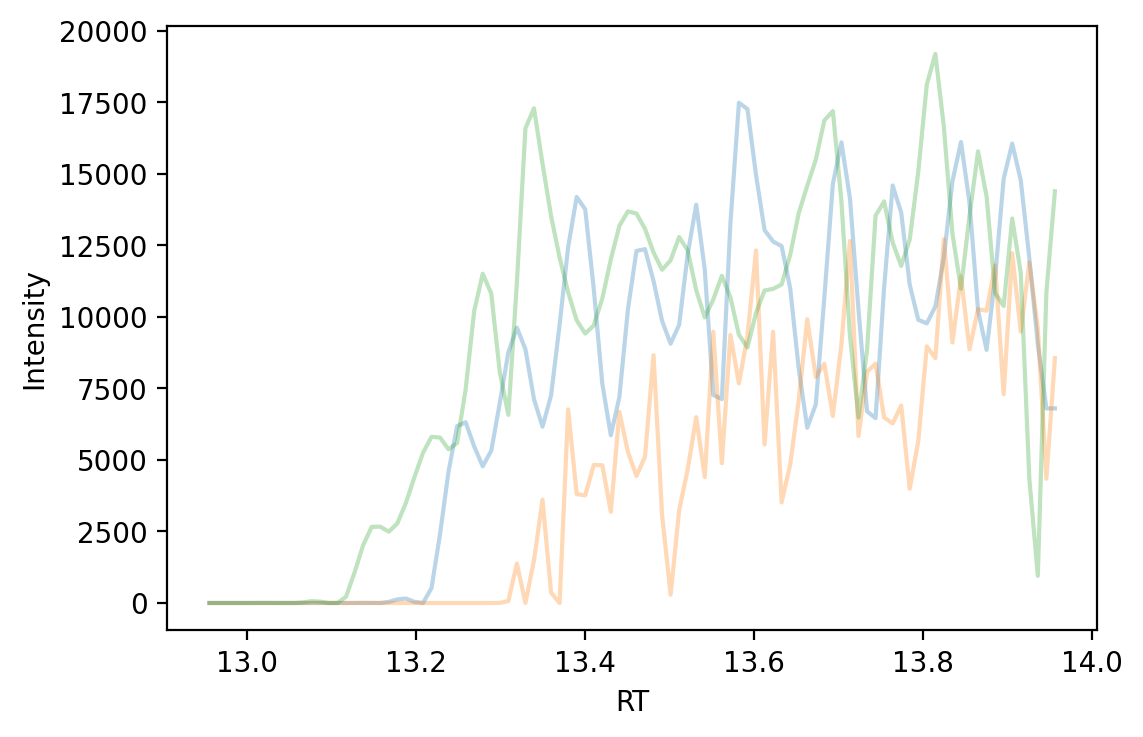

In [16]:
file = files[0]
inds = list(ms1_peaks_thresh[file].index.values)
rd.shuffle(inds)
for i in inds:
    if i not in ms1_peaks_curated[file].index.values:
        integ.plot_overlayedEIC([raw_data[f] for f in files],ms1_peaks_thresh[file].at[i,"mz"],ms1_peaks_thresh[file].at[i,"retention_time"]-.5,ms1_peaks_thresh[file].at[i,"retention_time"] + .5)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break